In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import os
from shinrl.solvers.vi.discrete import ViSolver
import shutil
import seaborn as sns

In [2]:
# use pretrained data in ./results if True
shortcut_run = False

# Figure 1. Analyzing DQL Results on MountainCar using ShinRL.

In [3]:
env = gym.make("ShinMountainCar-v0")
config = ViSolver.DefaultConfig(
    approx="nn",
    explore="eps_greedy", 
    device="cpu",
    eps_decay=5000,
    eps_end=0.05,
    target_update_interval=100,
    steps_per_epoch=100000
)
dqn = ViSolver.factory(config)
dqn.initialize(env, config=config)

2021-11-30 18:29.46 [info     ] set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 100, 'add_interval': 100, 'steps_per_epoch': 100000, 'explore': 'eps_greedy', 'exploit': 'greedy', 'approx': 'nn', 'loss_fn': 'mse_loss', 'num_samples': 4, 'minibatch_size': 32, 'buffer_size': 100000, 'target_update_interval': 100, 'kl_coef': 0.0, 'er_coef': 0.0, 'logp_clip': -100000000.0, 'use_double_q': False, 'noise_scale': 0.0, 'eps_end': 0.05, 'eps_warmup': 0, 'eps_decay': 5000, 'max_tmp': 1.0, 'hidden': 128, 'depth': 2, 'activation': 'ReLU', 'optimizer': 'Adam', 'lr': 0.001, 'device': 'cpu'} env_id=None solver_id=ViSolverDeepRL-0
2021-11-30 18:29.46 [info     ] set_env is called.             env_id=0 solver_id=ViSolverDeepRL-0
2021-11-30 18:29.46 [info     ] Solver is initialized.         env_id=0 solver_id=ViSolverDeepRL-0


/home/syuntoku14/miniconda3/envs/shinrl/lib/python3.9/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [4]:
if not shortcut_run:
    dqn.run()
    path = "./results/dqn"
    if os.path.exists(path):
        shutil.rmtree(path)
    dqn.save(path)

Epoch 0: 100%|█| 10

2021-11-30 18:35.46 [info     ] Epoch 1 has ended.             env_id=0 epoch_summary={'OptimalityGap': {'Average': 71.656147676961, 'Max': 84.61203251420373, 'Min': 64.38416845411841}, 'Return': {'Average': -75.35, 'Max': -23.25, 'Min': -200.0}, 'Loss': {'Average': 0.9119913938352838, 'Max': 26.75782012939453, 'Min': 0.0023561622947454453}} solver_id=ViSolverDeepRL-0


2021-11-30 18:35.46 [info     ] Histories are saved to ./results/dqn env_id=0 solver_id=ViSolverDeepRL-0


In [5]:
dqn.load("./results/dqn/")

2021-11-30 18:35.46 [info     ] set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 100, 'add_interval': 100, 'steps_per_epoch': 100000, 'explore': 'eps_greedy', 'exploit': 'greedy', 'approx': 'nn', 'loss_fn': 'mse_loss', 'num_samples': 4, 'minibatch_size': 32, 'buffer_size': 100000, 'target_update_interval': 100, 'kl_coef': 0.0, 'er_coef': 0.0, 'logp_clip': -100000000.0, 'use_double_q': False, 'noise_scale': 0.0, 'eps_end': 0.05, 'eps_warmup': 0, 'eps_decay': 5000, 'max_tmp': 1.0, 'hidden': 128, 'depth': 2, 'activation': 'ReLU', 'optimizer': 'Adam', 'lr': 0.001, 'device': 'cpu'} env_id=0 solver_id=ViSolverDeepRL-0
2021-11-30 18:35.46 [info     ] Load data from ./results/dqn/  env_id=0 solver_id=ViSolverDeepRL-0


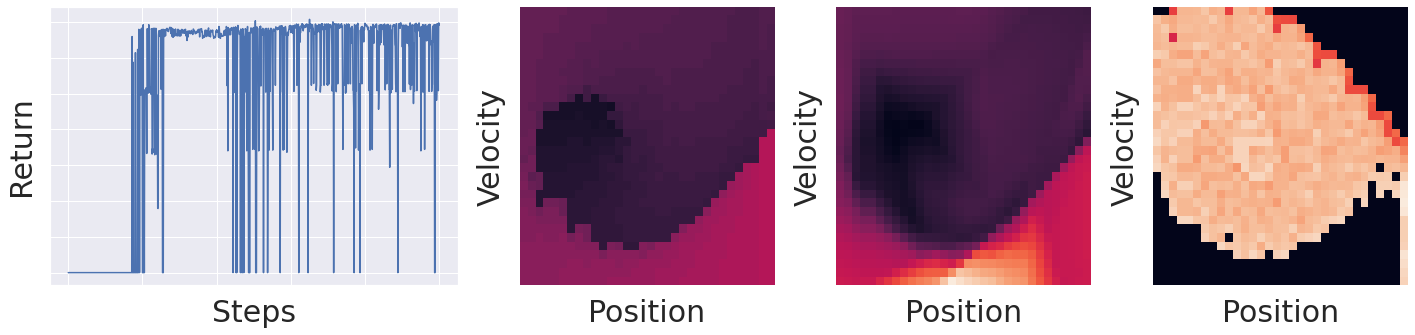

In [6]:
# plot return

performance = dqn.history.scalars["Return"]

# plot optimal Q values
v = env.calc_optimal_q()[:, -1] #.max(-1)  # dSxdA == (1025, 3)
lv = dqn.history.tbs["Q"][:, -1] #.max(-1)  # dSxdA == (1025, 3)
vmin, vmax = min(v.min(), lv.min()), max(v.max(), lv.max())

grid_kws = {"width_ratios": (0.4, 0.25, 0.25, 0.25)}
import seaborn as sns
sns.set(font_scale=1.5)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), gridspec_kw=grid_kws)


axes[0].plot(performance["x"], performance["y"])
axes[0].set_xlabel("Steps", fontsize=30)
axes[0].set_xticklabels([])
axes[0].set_ylabel("Return", fontsize=30)
axes[0].set_yticklabels([])

env.plot_S(v, ax=axes[1], cbar_ax=None, vmin=vmin, vmax=vmax, fontsize=30)
env.plot_S(lv, ax=axes[2], cbar_ax=None, vmin=vmin, vmax=vmax, fontsize=30)

# plot learnd Q values
from matplotlib.colors import LogNorm
pol = dqn.history.tbs["ExplorePolicy"]
visit = env.calc_visit(pol).sum(axis=(0, 2)) + 1e-30

env.plot_S(visit, ax=axes[3], fontsize=30, norm=LogNorm())


for i in range(1, 4):
    axes[i].set_xlabel("Position")
    axes[i].set_xticklabels([])
    axes[i].set_ylabel("Velocity")
    axes[i].set_yticklabels([])
fig.tight_layout()
plt.savefig("./results/return_Q_visit.svg", format="svg")

# Figure 3. Comparison of DQL with Different Settings on ShinMountainCar.

In [11]:
config = ViSolver.DefaultConfig(
    approx="nn",
    explore="eps_greedy",
    device="cpu",
    eps_decay=1,
    eps_end=0.0,
    eps_warmup=0,
    target_update_interval=100,
    steps_per_epoch=100000)
poor_dqn = ViSolver.factory(config)
poor_dqn.initialize(env, config=config)
if not shortcut_run:
    poor_dqn.run()
    path = "./results/poor_dqn"
    if os.path.exists(path):
        shutil.rmtree(path)
    poor_dqn.save(path)

    
config = ViSolver.DefaultConfig(
    approx="nn",
    explore="eps_greedy",
    device="cpu",
    eps_decay=1,
    eps_end=0.1,
    eps_warmup=0,
    target_update_interval=100,
    steps_per_epoch=100000)
better_dqn = ViSolver.factory(config)
better_dqn.initialize(env, config=config)
if not shortcut_run:
    better_dqn.run()
    path = "./results/better_dqn"
    if os.path.exists(path):
        shutil.rmtree(path)
    better_dqn.save(path)

    
config = ViSolver.DefaultConfig(
    approx="nn",
    explore="eps_greedy",
    device="cpu",
    eps_decay=1,
    eps_end=0.1,
    eps_warmup=0,
    target_update_interval=100,
    steps_per_epoch=100000,
    use_double_q=True,
)
ddqn = ViSolver.factory(config)
ddqn.initialize(env, config=config)
if not shortcut_run:
    ddqn.run()
    path = "./results/ddqn/"
    if os.path.exists(path):
        shutil.rmtree(path)
    ddqn.save("./results/ddqn/")

2021-09-17 20:32.22 [info     ] set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 100, 'add_interval': 100, 'steps_per_epoch': 100000, 'explore': 'eps_greedy', 'exploit': 'greedy', 'approx': 'nn', 'loss_fn': 'mse_loss', 'num_samples': 4, 'minibatch_size': 32, 'buffer_size': 100000, 'target_update_interval': 100, 'kl_coef': 0.0, 'er_coef': 0.0, 'logp_clip': -100000000.0, 'use_double_q': False, 'noise_scale': 0.0, 'eps_end': 0.0, 'eps_warmup': 0, 'eps_decay': 1, 'max_tmp': 1.0, 'hidden': 128, 'depth': 2, 'activation': 'ReLU', 'optimizer': 'Adam', 'lr': 0.001, 'device': 'cpu'} env_id=None solver_id=ViSolverDeepRL-4
2021-09-17 20:32.22 [info     ] set_env is called.             env_id=0 solver_id=ViSolverDeepRL-4
2021-09-17 20:32.22 [info     ] Solver is initialized.         env_id=0 solver_id=ViSolverDeepRL-4


Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [05:55<00:00, 280.92it/s]

2021-09-17 20:38.18 [info     ] Epoch 1 has ended.             env_id=0 epoch_summary={'OptimalityGap': {'Average': 72.18068877729795, 'Max': 84.61203251420373, 'Min': 16.219306240276914}, 'Return': {'Average': -81.12, 'Max': -25.25, 'Min': -200.0}, 'Loss': {'Average': 0.74379415226134, 'Max': 21.922834396362305, 'Min': 0.0009270585142076015}} solver_id=ViSolverDeepRL-4


2021-09-17 20:38.18 [info     ] Histories are saved to ./results/poor_dqn env_id=0 solver_id=ViSolverDeepRL-4
2021-09-17 20:38.18 [info     ] set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 100, 'add_interval': 100, 'steps_per_epoch': 100000, 'explore': 'eps_greedy', 'exploit': 'greedy', 'approx': 'nn', 'loss_fn': 'mse_loss', 'num_samples': 4, 'minibatch_size': 32, 'buffer_size': 100000, 'target_update_interval': 100, 'kl_coef': 0.0, 'er_coef': 0.0, 'logp_clip': -100000000.0, 'use_double_q': False, 'noise_scale': 0.0, 'eps_end': 0.1, 'eps_warmup': 0, 'eps_decay': 1, 'max_tmp': 1.0, 'hidden': 128, 'depth': 2, 'activation': 'ReLU', 'optimizer': 'Adam', 'lr': 0.001, 'device': 'cpu'} env_id=None solver_id=ViSolverDeepRL-5
2021-09-17 20:38.18 [info     ] set_env is called.             env_id=0 solver_id=ViSolverDeepRL-5
2021-09-17 20:38.18 [info     ] Solver is initialized.         env_id=0 solver_id=ViSolverDeepRL-5


Epoch 0: 100%|████████████████████| 100000/100000 [05:35<00:00, 298.03it/s]

2021-09-17 20:43.54 [info     ] Epoch 1 has ended.             env_id=0 epoch_summary={'OptimalityGap': {'Average': 72.07348853269295, 'Max': 84.61203251420373, 'Min': 68.39272627392681}, 'Return': {'Average': -72.9635, 'Max': -24.5, 'Min': -200.0}, 'Loss': {'Average': 0.7921247834339737, 'Max': 15.364270210266113, 'Min': 0.008465983904898167}} solver_id=ViSolverDeepRL-5
2021-09-17 20:43.54 [info     ] Histories are saved to ./results/better_dqn env_id=0 solver_id=ViSolverDeepRL-5
2021-09-17 20:43.54 [info     ] set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 100, 'add_interval': 100, 'steps_per_epoch': 100000, 'explore': 'eps_greedy', 'exploit': 'greedy', 'approx': 'nn', 'loss_fn': 'mse_loss', 'num_samples': 4, 'minibatch_size': 32, 'buffer_size': 100000, 'target_update_interval': 100, 'kl_coef': 0.0, 'er_coef': 0.0, 'logp_clip': -100000000.0, 'use_double_q': True, 'noise_scale': 0.0, 'eps_end': 0.1, 'eps_warmup': 0, 'eps_decay':


Epoch 0: 100%|████████████████████| 100000/100000 [05:45<00:00, 289.32it/s]

2021-09-17 20:49.39 [info     ] Epoch 1 has ended.             env_id=0 epoch_summary={'OptimalityGap': {'Average': 71.80733526764865, 'Max': 84.61203251420373, 'Min': 65.16984659492563}, 'Return': {'Average': -66.2965, 'Max': -26.5, 'Min': -200.0}, 'Loss': {'Average': 0.7522319311010651, 'Max': 7.620861530303955, 'Min': 0.004634065553545952}} solver_id=ViSolverDeepRL-6
2021-09-17 20:49.39 [info     ] Histories are saved to ./results/ddqn/ env_id=0 solver_id=ViSolverDeepRL-6


In [12]:
poor_dqn.load("./results/poor_dqn/")
better_dqn.load("./results/better_dqn/")
ddqn.load("./results/ddqn/")

2021-09-17 20:49.39 [info     ] set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 100, 'add_interval': 100, 'steps_per_epoch': 100000, 'explore': 'eps_greedy', 'exploit': 'greedy', 'approx': 'nn', 'loss_fn': 'mse_loss', 'num_samples': 4, 'minibatch_size': 32, 'buffer_size': 100000, 'target_update_interval': 100, 'kl_coef': 0.0, 'er_coef': 0.0, 'logp_clip': -100000000.0, 'use_double_q': False, 'noise_scale': 0.0, 'eps_end': 0.0, 'eps_warmup': 0, 'eps_decay': 1, 'max_tmp': 1.0, 'hidden': 128, 'depth': 2, 'activation': 'ReLU', 'optimizer': 'Adam', 'lr': 0.001, 'device': 'cpu'} env_id=0 solver_id=ViSolverDeepRL-4
2021-09-17 20:49.39 [info     ] Load data from ./results/poor_dqn/ env_id=0 solver_id=ViSolverDeepRL-4
2021-09-17 20:49.39 [info     ] set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 100, 'add_interval': 100, 'steps_per_epoch': 100000, 'explore': 'eps_greedy', 'exploit': '

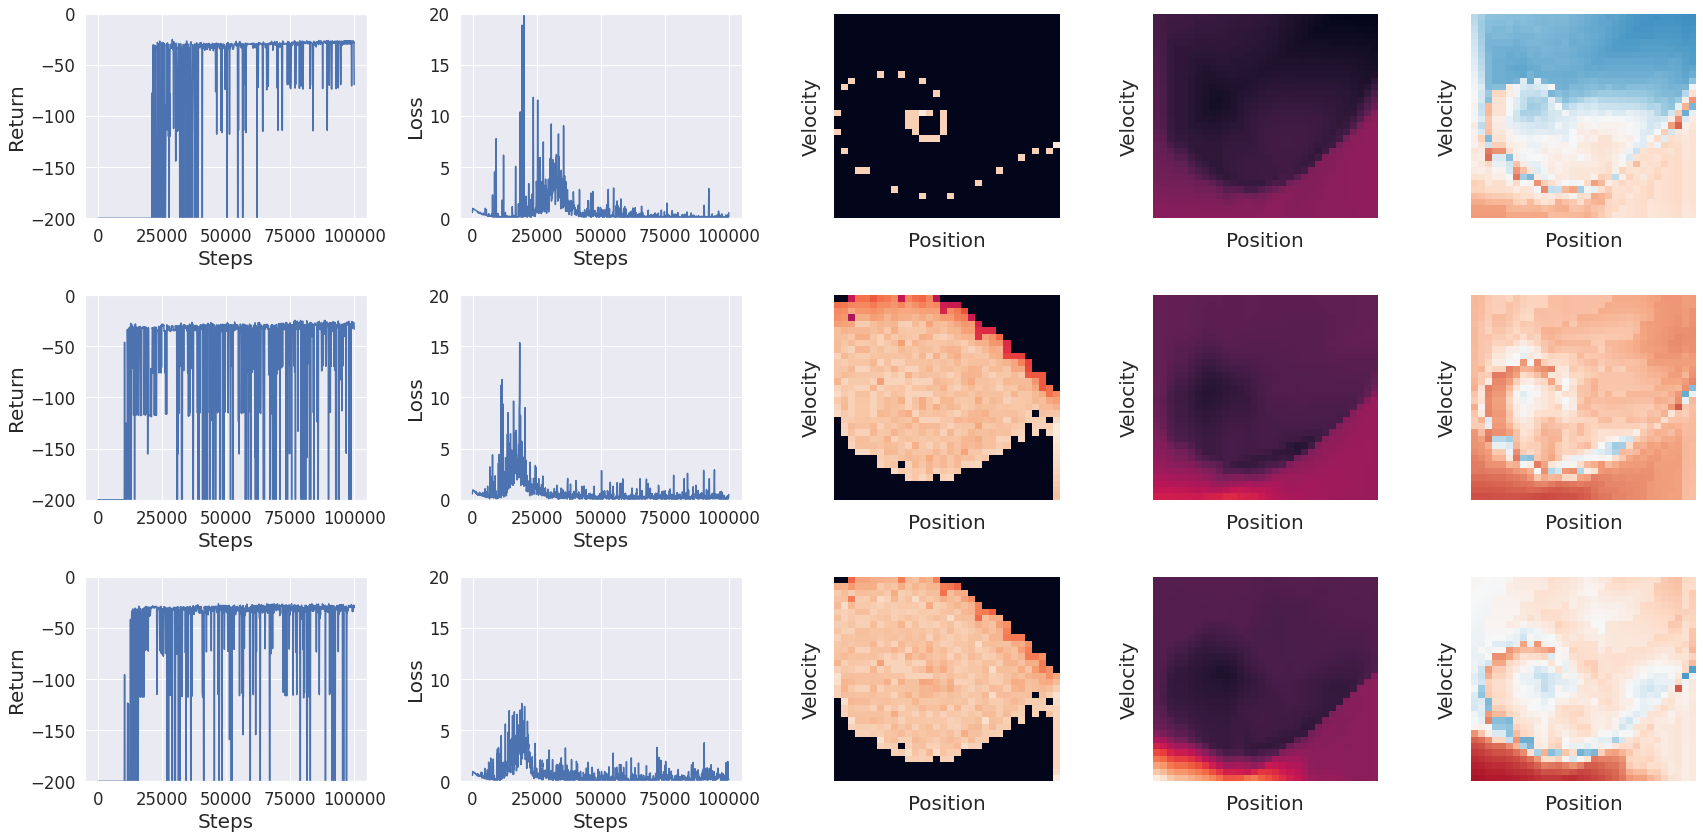

In [13]:
grid_kws = {"width_ratios": (0.25, 0.25, 0.2, 0.2, 0.2)}

import seaborn as sns
from matplotlib.colors import LogNorm, SymLogNorm
sns.set(font_scale=1.5)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(24, 12), gridspec_kw=grid_kws)
v = env.calc_optimal_q()[:, -1]  # dSxdA == (1025, 3)
lv = np.concatenate([dqn.history.tbs["Q"][:, -1] for dqn in [poor_dqn, better_dqn, ddqn]])
vmin, vmax = min(v.min(), lv.min()), max(v.max(), lv.max())

# env.plot_S(gap, ax=axes[0], cbar_ax=axes[-1], fontsize=30, norm=SymLogNorm(10, vmin=-100, vmax=25))

for i, dqn in enumerate([poor_dqn, better_dqn, ddqn]):
    performance = dqn.history.scalars["Return"]
    axes[i, 0].plot(performance["x"], performance["y"])
    axes[i, 0].set_ylim([-200, 0])
    axes[i, 0].set_xlabel("Steps", fontsize=20)
    # axes[i, 0].set_xticklabels([])
    axes[i, 0].set_ylabel("Return", fontsize=20)
    # axes[i, 0].set_yticklabels([])

    
    performance = dqn.history.scalars["Loss"]
    axes[i, 1].plot(performance["x"], performance["y"])
    axes[i, 1].set_ylim([0, 20])
    axes[i, 1].set_xlabel("Steps", fontsize=20)
    # axes[i, 1].set_xticklabels([])
    axes[i, 1].set_ylabel("Loss", fontsize=20)
    # axes[i, 1].set_yticklabels([])

    
    
    pol = dqn.history.tbs["ExplorePolicy"]
    visit = env.calc_visit(pol).sum(axis=(0, 2)) + 1e-30
    env.plot_S(visit, ax=axes[i, 2], fontsize=20, norm=LogNorm())
    
    lv = dqn.history.tbs["Q"][:, 2]
    env.plot_S(lv, ax=axes[i, 3], fontsize=20, vmin=vmin, vmax=vmax)
    
    v = env.calc_optimal_q()[:, 2]
    gap = (lv - v) # * (visit > 1e-30)
    env.plot_S(gap, ax=axes[i, 4], fontsize=20, cmap='RdBu_r', norm=SymLogNorm(5, vmin=-200, vmax=200))
    
    for j in range(2, 5):
        axes[i, j].set_xlabel("Position")
        axes[i, j].set_xticklabels([])
        axes[i, j].set_ylabel("Velocity")
        axes[i, j].set_yticklabels([])
        
plt.tight_layout()
plt.savefig("results/case_study_1.svg", format="svg")

# Case Study2: Comparing VI, KL-regularized VI, CVI, and Munchausen DQN with ShinRL

2021-09-17 13:13.47 [info     ] set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 1, 'add_interval': 1, 'steps_per_epoch': 150, 'explore': 'oracle', 'exploit': 'greedy', 'approx': 'tabular', 'loss_fn': 'mse_loss', 'num_samples': 10, 'minibatch_size': 32, 'buffer_size': 100000, 'target_update_interval': 1000, 'kl_coef': 0.0, 'er_coef': 0.0, 'logp_clip': -100000000.0, 'use_double_q': False, 'noise_scale': 1, 'eps_end': 0.1, 'eps_warmup': 0, 'eps_decay': 100000, 'max_tmp': 1.0, 'hidden': 128, 'depth': 2, 'activation': 'ReLU', 'optimizer': 'Adam', 'lr': 0.001, 'device': 'cpu'} env_id=None solver_id=ViSolverTabularDP-4
2021-09-17 13:13.47 [info     ] set_env is called.             env_id=0 solver_id=ViSolverTabularDP-4
2021-09-17 13:13.47 [info     ] Solver is initialized.         env_id=0 solver_id=ViSolverTabularDP-4


Epoch 0: 100%|█| 150/150 [00:00<

2021-09-17 13:13.48 [info     ] Epoch 1 has ended.             env_id=0 epoch_summary={'OptimalityGap': {'Average': 15.593929048205055, 'Max': 18.694335139602924, 'Min': 7.812706083864326}, 'Return': {'Average': 1.4890514701501851, 'Max': 18.11086296801885, 'Min': 7.065285518479653e-05}} solver_id=ViSolverTabularDP-4
2021-09-17 13:13.48 [info     ] set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 1, 'add_interval': 1, 'steps_per_epoch': 150, 'explore': 'oracle', 'exploit': 'greedy', 'approx': 'tabular', 'loss_fn': 'mse_loss', 'num_samples': 10, 'minibatch_size': 32, 'buffer_size': 100000, 'target_update_interval': 1000, 'kl_coef': 1.0, 'er_coef': 0.0, 'logp_clip': -100000000.0, 'use_double_q': False, 'noise_scale': 1, 'eps_end': 0.1, 'eps_warmup': 0, 'eps_decay': 100000, 'max_tmp': 1.0, 'hidden': 128, 'depth': 2, 'activation': 'ReLU', 'optimizer': 'Adam', 'lr': 0.001, 'device': 'cpu'} env_id=0 solver_id=ViSolverTabularDP-4
2021-09-


Epoch 0: 100%|█| 150/150 [00:00<

2021-09-17 13:13.48 [info     ] Epoch 1 has ended.             env_id=1 epoch_summary={'OptimalityGap': {'Average': 2.011611757186041, 'Max': 17.698736320132898, 'Min': 0.0}, 'Return': {'Average': 16.168692825911254, 'Max': 18.112674767557827, 'Min': 0.0003791539100351865}} solver_id=ViSolverTabularDP-4
2021-09-17 13:13.48 [info     ] set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 1, 'add_interval': 1, 'steps_per_epoch': 150, 'explore': 'oracle', 'exploit': 'greedy', 'approx': 'tabular', 'loss_fn': 'mse_loss', 'num_samples': 10, 'minibatch_size': 32, 'buffer_size': 100000, 'target_update_interval': 1000, 'kl_coef': 0.0, 'er_coef': 1.0, 'logp_clip': -100000000.0, 'use_double_q': False, 'noise_scale': 1, 'eps_end': 0.1, 'eps_warmup': 0, 'eps_decay': 100000, 'max_tmp': 1.0, 'hidden': 128, 'depth': 2, 'activation': 'ReLU', 'optimizer': 'Adam', 'lr': 0.001, 'device': 'cpu'} env_id=1 solver_id=ViSolverTabularDP-4
2021-09-17 13:13.48 [i


Epoch 0: 100%|█| 150/150 [00:00<

2021-09-17 13:13.48 [info     ] Epoch 1 has ended.             env_id=2 epoch_summary={'OptimalityGap': {'Average': 14.844081110492121, 'Max': 18.620371151300382, 'Min': 8.852550870742736}, 'Return': {'Average': 3.158567307180717, 'Max': 17.720011841189507, 'Min': 0.001045387853825948}} solver_id=ViSolverTabularDP-4
2021-09-17 13:13.48 [info     ] set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 1, 'add_interval': 1, 'steps_per_epoch': 150, 'explore': 'oracle', 'exploit': 'softmax', 'approx': 'tabular', 'loss_fn': 'mse_loss', 'num_samples': 10, 'minibatch_size': 32, 'buffer_size': 100000, 'target_update_interval': 1000, 'kl_coef': 1.0, 'er_coef': 1.0, 'logp_clip': -100000000.0, 'use_double_q': False, 'noise_scale': 1, 'eps_end': 0.1, 'eps_warmup': 0, 'eps_decay': 100000, 'max_tmp': 1.0, 'hidden': 128, 'depth': 2, 'activation': 'ReLU', 'optimizer': 'Adam', 'lr': 0.001, 'device': 'cpu'} env_id=2 solver_id=ViSolverTabularDP-4
2021-09-


Epoch 0: 100%|█| 150/150 [00:00<

2021-09-17 13:13.48 [info     ] Epoch 1 has ended.             env_id=3 epoch_summary={'OptimalityGap': {'Average': 8.310336133111337, 'Max': 16.623665803480066, 'Min': 2.083340755990829}, 'Return': {'Average': 11.06054253216086, 'Max': 17.453131288034985, 'Min': 0.049411996168791106}} solver_id=ViSolverTabularDP-4


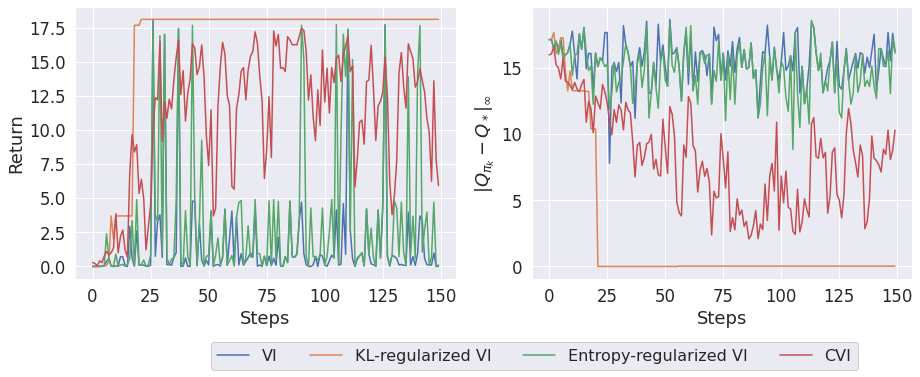

In [10]:
from shinrl.envs.maze import Maze, spec_from_str

spec = spec_from_str("SOOO\\" + "O###\\" + "OOOO\\" + "O#RO\\")
env = Maze(spec, trans_eps=0.1, horizon=25)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

config = ViSolver.DefaultConfig()
config.update(
    {
        "add_interval": 1,
        "eval_interval": 1,
        "approx": "tabular",
        "discount": 0.99,
        "exploit": "greedy",
        "explore": "oracle",
        "seed": 0,
        "steps_per_epoch": 150,
        "num_samples": 10,
        "noise_scale": 1,
        "er_coef": 0.0,
        "kl_coef": 0.0
    }
)
solver = ViSolver.factory(config)

# Value Iteration
solver.initialize(env, config=config)
solver.run()
gap = solver.history.scalars["OptimalityGap"]
ret = solver.history.scalars["Return"]
axes[1].plot(gap["x"], gap["y"])
axes[0].plot(ret["x"], ret["y"], label=f"VI")

config.kl_coef = 1.0
config.er_coef = 0.0
# config.exploit = "softmax"
config.exploit = "greedy"
# config.max_tmp = 1 / 1.0
solver.initialize(env, config=config)
solver.run()
gap = solver.history.scalars["OptimalityGap"]
ret = solver.history.scalars["Return"]
# axes[1].plot(gap["x"], gap["y"], label=r"$(\tau, \lambda) = (1.0, 0)$")
# axes[0].plot(ret["x"], ret["y"], label=r"$(\tau, \lambda) = (1.0, 0)$")
axes[1].plot(gap["x"], gap["y"])
axes[0].plot(ret["x"], ret["y"], label=r"KL-regularized VI")

config.kl_coef = 0.0
config.er_coef = 1.0
config.exploit = "greedy"
# config.exploit = "softmax"
# config.max_tmp = 1 / 1.0
solver.initialize(env, config=config)
solver.run()
gap = solver.history.scalars["OptimalityGap"]
ret = solver.history.scalars["Return"]
axes[1].plot(gap["x"], gap["y"])
axes[0].plot(ret["x"], ret["y"], label=r"Entropy-regularized VI")

config.kl_coef = 1.0
config.er_coef = 1.0
config.exploit = "greedy"
config.exploit = "softmax"
# config.max_tmp = 1 / 2.0
solver.initialize(env, config=config)
solver.run()
gap = solver.history.scalars["OptimalityGap"]
ret = solver.history.scalars["Return"]
axes[1].plot(gap["x"], gap["y"])
axes[0].plot(ret["x"], ret["y"], label=r"CVI")

# axes[1].legend(loc="lower right")
fig.legend(loc="lower center", framealpha=1.0, fontsize=16, ncol=4, bbox_to_anchor=(0.55, -0.15))
axes[1].set_ylabel("$\|Q_{\pi_k} - Q_*\|_\infty$", fontsize=18)
axes[1].set_xlabel("Steps", fontsize=18)
axes[0].set_ylabel("Return", fontsize=18)
axes[0].set_xlabel("Steps", fontsize=18)
# plt.tight_layout()
fig.savefig("results/CVI.svg", format="svg", bbox_inches='tight')

In [21]:
from shinrl import utils
env = utils.make_minatar("breakout")

config = ViSolver.DefaultConfig(
    add_interval=10,
    eval_interval=1000,
    steps_per_epoch=1000000,
    approx="nn",
    explore="eps_greedy",
    exploit="greedy",
    num_samples=4,
    eps_end=0.1,
    eps_decay=10**5,
    eps_warmup=5000,
    logp_clip=-1,
    lr=2.5*1e-4,
    minibatch_size=32,
    buffer_size=1e5,
    optimizer="RMSprop",
    target_update_interval=1000,
    loss_fn="smooth_l1_loss",
    device="cpu",
    kl_coef=0.0,
    er_coef=0.0
)
dqn_breakout = ViSolver.factory(config)
dqn_breakout.initialize(env, config=config)
if not shortcut_run:
    dqn_breakout.run()
    path = "./results/dqn_breakout/"
    if os.path.exists(path):
        shutil.rmtree(path)
    dqn_breakout.save("./results/dqn_breakout/")


config = ViSolver.DefaultConfig(
    add_interval=10,
    eval_interval=1000,
    steps_per_epoch=1000000,
    approx="nn",
    explore="eps_greedy",
    exploit="greedy",
    num_samples=4,
    eps_end=0.1,
    eps_decay=10**5,
    eps_warmup=5000,
    logp_clip=-1,
    lr=2.5*1e-4,
    minibatch_size=32,
    buffer_size=1e5,
    optimizer="RMSprop",
    target_update_interval=1000,
    loss_fn="smooth_l1_loss",
    device="cpu",
    kl_coef=0.027,
    er_coef=0.003
)
mdqn_breakout = ViSolver.factory(config)
mdqn_breakout.initialize(env, config=config)
if not shortcut_run:
    mdqn_breakout.run()
    path = "./results/mdqn_breakout/"
    if os.path.exists(path):
        shutil.rmtree(path)
    mdqn_breakout.save("./results/mdqn_breakout/")

2021-09-17 13:16.27 [info     ] set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 1000, 'add_interval': 10, 'steps_per_epoch': 1000000, 'explore': 'eps_greedy', 'exploit': 'greedy', 'approx': 'nn', 'loss_fn': 'smooth_l1_loss', 'num_samples': 4, 'minibatch_size': 32, 'buffer_size': 100000.0, 'target_update_interval': 1000, 'kl_coef': 0.0, 'er_coef': 0.0, 'logp_clip': -1, 'use_double_q': False, 'noise_scale': 0.0, 'eps_end': 0.1, 'eps_warmup': 5000, 'eps_decay': 100000, 'max_tmp': 1.0, 'hidden': 128, 'depth': 2, 'activation': 'ReLU', 'optimizer': 'RMSprop', 'lr': 0.00025, 'device': 'cpu'} env_id=None solver_id=ViSolverDeepRL-18
2021-09-17 13:16.27 [info     ] set_env is called.             env_id=0 solver_id=ViSolverDeepRL-18
2021-09-17 13:16.27 [info     ] Solver is initialized.         env_id=0 solver_id=ViSolverDeepRL-18
2021-09-17 13:16.27 [info     ] set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials

In [12]:
dqn_breakout.load("./results/dqn_breakout/", device="cpu")
mdqn_breakout.load("./results/mdqn_breakout/", device="cpu")

2021-09-17 13:13.49 [info     ] set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 1000, 'add_interval': 10, 'steps_per_epoch': 1000000, 'explore': 'eps_greedy', 'exploit': 'greedy', 'approx': 'nn', 'loss_fn': 'smooth_l1_loss', 'num_samples': 4, 'minibatch_size': 32, 'buffer_size': 100000.0, 'target_update_interval': 1000, 'kl_coef': 0.0, 'er_coef': 0.0, 'logp_clip': -1, 'use_double_q': False, 'noise_scale': 0.0, 'eps_end': 0.1, 'eps_warmup': 5000, 'eps_decay': 100000, 'max_tmp': 1.0, 'hidden': 128, 'depth': 2, 'activation': 'ReLU', 'optimizer': 'RMSprop', 'lr': 0.00025, 'device': 'cuda'} env_id=0 solver_id=ViSolverDeepRL-5
2021-09-17 13:13.49 [info     ] Load data from ./results/dqn_breakout/ env_id=0 solver_id=ViSolverDeepRL-5
2021-09-17 13:13.49 [info     ] set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 1000, 'add_interval': 10, 'steps_per_epoch': 1000000, 'explore': 'eps_gr

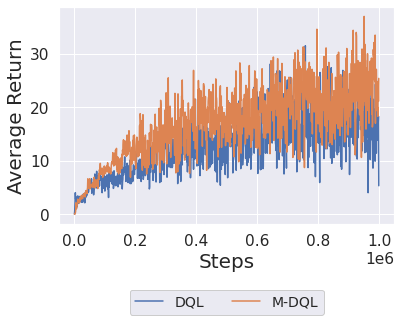

In [13]:
sns.set(font_scale=1.4)
performance = dqn_breakout.history.scalars["Return"]
plt.plot(performance["x"], performance["y"], label=f"DQL")
performance = mdqn_breakout.history.scalars["Return"]
plt.plot(performance["x"], performance["y"], label=f"M-DQL")
plt.ylabel("Average Return", fontsize=20)
plt.xlabel("Steps", fontsize=20)
plt.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))
plt.legend(loc="lower center", framealpha=1.0, fontsize=14, ncol=2, bbox_to_anchor=(0.5, -0.45))
plt.savefig("./results/Breakout.svg", bbox_inches='tight')

# Case Study3: Evaluating Poliycy Iteration and Actor Critic

In [7]:
from shinrl.solvers.pi.discrete.solver import PiSolverDeepRL
import torch

In [8]:
env = gym.make("ShinPendulum-v0")

class CaseStudySolver(PiSolverDeepRL):
    def _make_noise(self, rew):
        noise = 4.9 + 0.1 * torch.randn_like(rew)
        noise = torch.where(rew < -5, noise, torch.zeros_like(rew))
        return noise

config = CaseStudySolver.DefaultConfig(
    approx="nn", 
    explore="eps_greedy", 
    device="cpu", 
    eps_decay=1, 
    eps_end=0.1, 
    noise_scale=1.0,
    target_update_interval=100, 
    steps_per_epoch=10000,
    add_interval=1,
    eval_interval=10,
)


In [9]:
import torch
solvers = {}
for er_coef in [0.0, 0.001, 0.1, 1.0]:
    label = "$\lambda=$" + str(er_coef)
    solver = CaseStudySolver()
    config.er_coef = er_coef
    solver.initialize(env, config=config)
    if not shortcut_run:
        solver.run()
        path = "./results/" + label
        if os.path.exists(path):
            shutil.rmtree(path)
        solver.save(path)
        buf = solver.buffer.get_all_transitions()
        torch.save(buf, os.path.join(path, "buffer.pkl"))
    solvers[label] = solver

2021-11-30 18:35.47 [info     ] set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 10, 'add_interval': 1, 'steps_per_epoch': 10000, 'explore': 'eps_greedy', 'exploit': 'greedy', 'approx': 'nn', 'loss_fn': 'mse_loss', 'num_samples': 4, 'minibatch_size': 32, 'buffer_size': 100000, 'target_update_interval': 100, 'er_coef': 0.0, 'noise_scale': 1.0, 'eps_end': 0.1, 'eps_warmup': 0, 'eps_decay': 1, 'max_tmp': 1.0, 'hidden': 128, 'depth': 2, 'activation': 'ReLU', 'optimizer': 'Adam', 'actor_lr': 0.001, 'critic_lr': 0.001, 'device': 'cpu'} env_id=None solver_id=CaseStudySolver-1
2021-11-30 18:35.47 [info     ] set_env is called.             env_id=0 solver_id=CaseStudySolver-1
2021-11-30 18:35.47 [info     ] Solver is initialized.         env_id=0 solver_id=CaseStudySolver-1


Epoch 0: 100%|██████████████| 10000/10000 [01:26<00:00, 115.27it/s]

2021-11-30 18:37.14 [info     ] Epoch 1 has ended.             env_id=0 epoch_summary={'OptimalityGap': {'Average': 744.3696978779126, 'Max': 806.2787674788349, 'Min': 744.3077268372713}, 'Return': {'Average': -1489.0386632657485, 'Max': -1488.6563259865734, 'Min': -1870.993605162169}, 'Loss': {'Average': 0.0014463162117432037, 'Max': 1.6256719827651978, 'Min': 0.0}} solver_id=CaseStudySolver-1
2021-11-30 18:37.14 [info     ] Histories are saved to ./results/$\lambda=$0.0 env_id=0 solver_id=CaseStudySolver-1
2021-11-30 18:37.14 [info     ] set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 10, 'add_interval': 1, 'steps_per_epoch': 10000, 'explore': 'eps_greedy', 'exploit': 'greedy', 'approx': 'nn', 'loss_fn': 'mse_loss', 'num_samples': 4, 'minibatch_size': 32, 'buffer_size': 100000, 'target_update_interval': 100, 'er_coef': 0.001, 'noise_scale': 1.0, 'eps_end': 0.1, 'eps_warmup': 0, 'eps_decay': 1, 'max_tmp': 1.0, 'hidden': 128, 'dep


Epoch 0: 100%|██████████████| 10000/10000 [01:27<00:00, 114.70it/s]


2021-11-30 18:38.41 [info     ] Epoch 1 has ended.             env_id=0 epoch_summary={'OptimalityGap': {'Average': 596.0381856691465, 'Max': 806.2787674788349, 'Min': 70.12594937689282}, 'Return': {'Average': -692.5114600863335, 'Max': -57.65268420000576, 'Min': -1912.1258902343811}, 'Loss': {'Average': 1327.5159326904297, 'Max': 4659.3017578125, 'Min': 39.347049713134766}} solver_id=CaseStudySolver-2
2021-11-30 18:38.41 [info     ] Histories are saved to ./results/$\lambda=$0.001 env_id=0 solver_id=CaseStudySolver-2
2021-11-30 18:38.41 [info     ] set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 10, 'add_interval': 1, 'steps_per_epoch': 10000, 'explore': 'eps_greedy', 'exploit': 'greedy', 'approx': 'nn', 'loss_fn': 'mse_loss', 'num_samples': 4, 'minibatch_size': 32, 'buffer_size': 100000, 'target_update_interval': 100, 'er_coef': 0.1, 'noise_scale': 1.0, 'eps_end': 0.1, 'eps_warmup': 0, 'eps_decay': 1, 'max_tmp': 1.0, 'hidden': 1

Epoch 0: 100%|██████████████| 10000/10000 [01:27<00:00, 114.82it/s]


2021-11-30 18:40.08 [info     ] Epoch 1 has ended.             env_id=0 epoch_summary={'OptimalityGap': {'Average': 571.3635065221989, 'Max': 806.2787674788349, 'Min': 539.4988149485264}, 'Return': {'Average': -1235.8696203477948, 'Max': -1076.44586652629, 'Min': -1920.7620913849373}, 'Loss': {'Average': 7.543310209666193, 'Max': 36.50913619995117, 'Min': 0.10771842300891876}} solver_id=CaseStudySolver-3
2021-11-30 18:40.08 [info     ] Histories are saved to ./results/$\lambda=$0.1 env_id=0 solver_id=CaseStudySolver-3
2021-11-30 18:40.08 [info     ] set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 10, 'add_interval': 1, 'steps_per_epoch': 10000, 'explore': 'eps_greedy', 'exploit': 'greedy', 'approx': 'nn', 'loss_fn': 'mse_loss', 'num_samples': 4, 'minibatch_size': 32, 'buffer_size': 100000, 'target_update_interval': 100, 'er_coef': 1.0, 'noise_scale': 1.0, 'eps_end': 0.1, 'eps_warmup': 0, 'eps_decay': 1, 'max_tmp': 1.0, 'hidden': 1

Epoch 0: 100%|██████████████| 10000/10000 [01:26<00:00, 115.03it/s]

2021-11-30 18:41.35 [info     ] Epoch 1 has ended.             env_id=0 epoch_summary={'OptimalityGap': {'Average': 601.4538223097993, 'Max': 806.2787674788349, 'Min': 495.7096844559244}, 'Return': {'Average': -489.051889918936, 'Max': -65.59939100185409, 'Min': -1881.61067984834}, 'Loss': {'Average': 0.26399033592119814, 'Max': 0.6667591333389282, 'Min': 0.07917138189077377}} solver_id=CaseStudySolver-4
2021-11-30 18:41.35 [info     ] Histories are saved to ./results/$\lambda=$1.0 env_id=0 solver_id=CaseStudySolver-4


2021-11-30 18:41.35 [info     ] set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 10, 'add_interval': 1, 'steps_per_epoch': 10000, 'explore': 'eps_greedy', 'exploit': 'greedy', 'approx': 'nn', 'loss_fn': 'mse_loss', 'num_samples': 4, 'minibatch_size': 32, 'buffer_size': 100000, 'target_update_interval': 100, 'er_coef': 1.0, 'noise_scale': 1.0, 'eps_end': 0.1, 'eps_warmup': 0, 'eps_decay': 1, 'max_tmp': 1.0, 'hidden': 128, 'depth': 2, 'activation': 'ReLU', 'optimizer': 'Adam', 'actor_lr': 0.001, 'critic_lr': 0.001, 'device': 'cpu'} env_id=None solver_id=CaseStudySolver-5
2021-11-30 18:41.35 [info     ] set_env is called.             env_id=0 solver_id=CaseStudySolver-5
2021-11-30 18:41.35 [info     ] Solver is initialized.         env_id=0 solver_id=CaseStudySolver-5
2021-11-30 18:41.35 [info     ] set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 10, 'add_interval': 1, 'steps_per

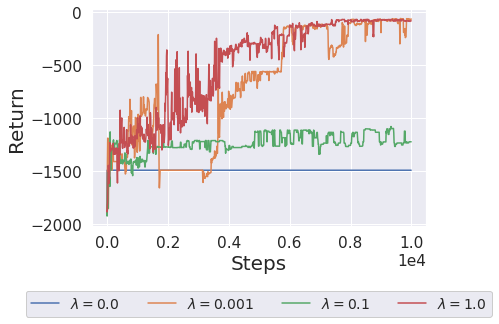

In [10]:
sns.set(font_scale=1.4)
solvers = {}
for er_coef in [0.0, 0.001, 0.1, 1.0]:
    label = "$\lambda=$" + str(er_coef)
    path = "./results/" + label
    solver = CaseStudySolver()
    solver.initialize(env, config=config)
    solver.load(path)
    solvers[label] = solver
    performance = solver.history.scalars["Return"]
    x, y = performance["x"], performance["y"]
    plt.plot(x, y, label=label)

plt.ylabel("Return", fontsize=20)
plt.xlabel("Steps", fontsize=20)
plt.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))
plt.legend(loc="lower center", framealpha=1.0, fontsize=14, ncol=4, bbox_to_anchor=(0.5, -0.45))
plt.savefig("./results/SAC.svg", bbox_inches='tight')

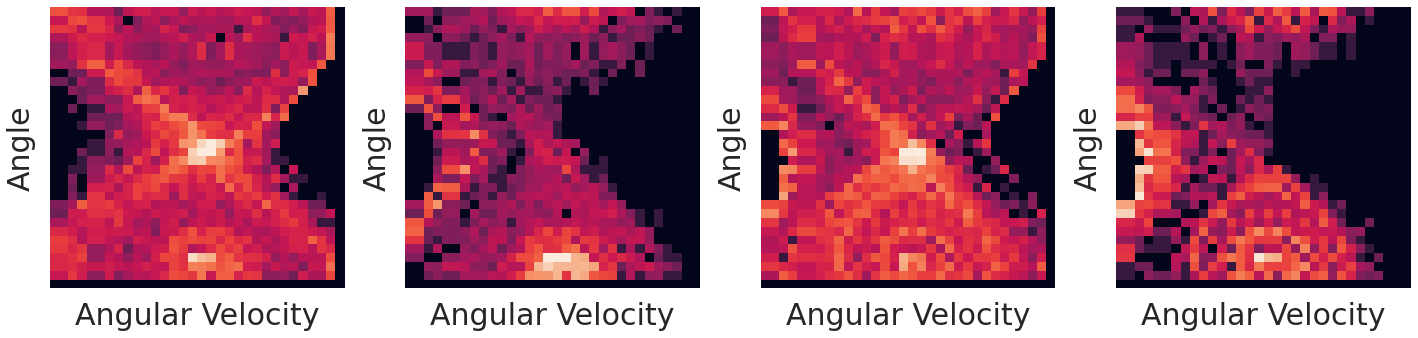

In [11]:
import torch
buffers = {}
for er_coef in [1.0, 0.1, 0.001, 0.0]:
    label = "$\lambda=$" + str(er_coef)
    path = "./results/" + label
    with open(os.path.join(path, "buffer.pkl"), mode="rb") as f:
        buf = torch.load(f)
    solvers[label].buffer.add(**buf)

# plot learnd Q values
from matplotlib.colors import LogNorm, SymLogNorm
grid_kws = {"width_ratios": (0.25, 0.25, 0.25, 0.25)}
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), gridspec_kw=grid_kws)

vmax = 0
for i, er_coef in enumerate([1.0, 0.1, 0.001, 0.0]):
    label = "$\lambda=$" + str(er_coef)
    visit = env.count_visit(solvers[label].buffer).sum(1)
    vmax = visit.max()
    
for i, er_coef in enumerate([1.0, 0.1, 0.001, 0.0]):
    label = "$\lambda=$" + str(er_coef)
    visit = env.count_visit(solvers[label].buffer).sum(1) / vmax
    env.plot_S(visit, ax=axes[i], fontsize=30, vmin=0, vmax=1.0, norm=SymLogNorm(0.001, vmin=0, vmax=1.0))


    
for i in range(4):
    axes[i].set_xlabel("Angular Velocity")
    axes[i].set_xticklabels([])
    axes[i].set_ylabel("Angle")
    axes[i].set_yticklabels([])
fig.tight_layout()
fig.savefig("./results/SACvisit.svg", bbox_inches='tight')